In [1]:
!which python
!pip install numpy

/Users/xusu/anaconda3/envs/EDA/bin/python
Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [2]:
import numpy as np

In [4]:
!ls HACS/HA

HACS_clips_v1.1.1.csv     HACS_segments_v1.1.1.json


In [8]:
with open('HACS/HACS_segments_v1.1.1.json') as f:
    import json
    json_data = json.load(f)

In [9]:
json_data.keys()

dict_keys(['database', 'taxonomy', 'version'])

In [10]:
json_data['taxonomy']

[{'nodeId': 389,
  'nodeName': 'Applying sunscreen',
  'parentId': 269,
  'parentName': 'Health-related self care'},
 {'nodeId': 269,
  'nodeName': 'Health-related self care',
  'parentId': 270,
  'parentName': 'Health-related Self Care'},
 {'nodeId': 270,
  'nodeName': 'Health-related Self Care',
  'parentId': 2,
  'parentName': 'Personal Care'},
 {'nodeId': 271,
  'nodeName': 'Arm wrestling',
  'parentId': 272,
  'parentName': 'Wrestling'},
 {'nodeId': 272,
  'nodeName': 'Wrestling',
  'parentId': 17,
  'parentName': 'Participating in Sports, Exercise, or Recreation'},
 {'nodeId': 273,
  'nodeName': 'Assembling bicycle',
  'parentId': 56,
  'parentName': 'Vehicle repair and maintenance (by self)'},
 {'nodeId': 274, 'nodeName': 'BMX', 'parentId': 275, 'parentName': 'Biking'},
 {'nodeId': 275,
  'nodeName': 'Biking',
  'parentId': 17,
  'parentName': 'Participating in Sports, Exercise, or Recreation'},
 {'nodeId': 276,
  'nodeName': 'Baking cookies',
  'parentId': 31,
  'parentName': '

In [11]:
# Now analyze the taxonomy 
p_dict = {}
n_dict = {}
for node in json_data['taxonomy']:
    if node['nodeName'] not in n_dict.keys():
        n_dict[node['nodeName']] = node['nodeId']
    else:
        assert n_dict['nodeName'] == node['nodeId']
    if node['parentName'] not in p_dict.keys():
        p_dict[node['parentName']] = node['parentId']
    else:
        assert p_dict[node['parentName']] == node['parentId']
print(f'There are {len(p_dict.keys())} parent classes and {len(n_dict.keys())} node classes.')        

There are 73 parent classes and 272 node classes.


In [7]:
# Now there is something strange, we all know that activityNet has 200 classes, but why 272 classes here?
# We will explore it later when dealing with the field 'database'.

In [12]:
annotation = json_data['database']
annotation

{'--0edUL8zmA': {'annotations': [{'label': 'Dodgeball',
    'segment': [5.4, 11.6]},
   {'label': 'Dodgeball', 'segment': [12.6, 88.16]}],
  'duration': '92.166667',
  'subset': 'training',
  'url': 'https://www.youtube.com/watch?v=--0edUL8zmA'},
 '--8jh-DkPK4': {'annotations': [{'label': 'Playing piano',
    'segment': [18.31, 21.85]},
   {'label': 'Playing piano', 'segment': [25.31, 29.99]},
   {'label': 'Playing piano', 'segment': [30.66, 35.4]},
   {'label': 'Playing piano', 'segment': [60.06, 66.5]},
   {'label': 'Playing piano', 'segment': [71.35, 77.21]},
   {'label': 'Playing piano', 'segment': [80.18, 88.27]},
   {'label': 'Playing piano', 'segment': [90.09, 98.7]},
   {'label': 'Playing piano', 'segment': [102.31, 150.33]},
   {'label': 'Playing piano', 'segment': [159.95, 170.11]},
   {'label': 'Playing piano', 'segment': [178.43, 200.68]},
   {'label': 'Playing piano', 'segment': [201.21, 210.14]}],
  'duration': '220.5',
  'subset': 'training',
  'url': 'https://www.youtub

In [13]:
print(f'There are {len(annotation.keys())} videos.')

There are 49582 videos.


In [17]:
class SegmentInstance():
    count = 0
    
    def __init__(self, action_label, video_id, start, end, duration):
        self.action_label = action_label
        self.video_id = video_id
        self.start = start
        self.end = end
        self.duration = self.end - self.start
        self.coverage = self.duration / duration
    @classmethod
    def inc_count(cls):
        cls.count += 1
    @classmethod
    def reset_count(cls):
        cls.count = 0

In [18]:
class VideoInstance():
    count = 0
    
    def __init__(self,
                 video_id,
                 duration=None,
                 subset=None,
                 resolution=None,
                 url=None,
                 **kwargs):
        self.segments = []
        self.video_id = video_id
        self.duration = duration
        self.subset = subset
        self.resolution = resolution
        self.url = url
        
    @classmethod
    def inc_count(cls):
        cls.count += 1
    @classmethod
    def reset_count(cls):
        cls.count = 0
        
    def add_seg(self, seg_instance):
        self.segments.append(seg_instance)
    
    def get_num_seg(self):
        return len(self.segments)

In [19]:
# Now read all the action instance and get some insights of them
all_segs = []
all_videos = []
VideoInstance.reset_count()
SegmentInstance.reset_count()

for video_id, video_info in annotation.items():
    new_video = VideoInstance(video_id, **video_info)
    VideoInstance.inc_count()
    for seg in video_info['annotations']:
        new_seg = SegmentInstance(seg['label'],
                                  video_id,
                                  float(seg['segment'][0]),
                                  float(seg['segment'][1]),
                                  float(video_info['duration'])
                                 )
        new_video.add_seg(new_seg)
        SegmentInstance.inc_count()
        all_segs.append(new_seg)
    all_videos.append(new_video)
        
assert len(all_segs) == SegmentInstance.count
assert len(all_videos) == VideoInstance.count

print(f'There are {SegmentInstance.count} segments and {VideoInstance.count} videos.'
     f'Therefore the global average segments for one video is {(SegmentInstance.count / VideoInstance.count)}')

There are 122304 segments and 49582 videos.Therefore the global average segments for one video is 2.466701625589932


In [20]:
%time !pip install matplotlib

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
CPU times: user 18.4 ms, sys: 17.4 ms, total: 35.8 ms
Wall time: 1.23 s


In [21]:
import matplotlib

In [22]:
# Now lets check if all segments are within taxonomy and how many are untouched
# Besides, I want to plot the distribution of seg lengths and its coverage
seg_lengths = []
coverages = []
all_classes = set(n_dict.keys())
class_distribution = []
untouched_action = []
for seg in all_segs:
    if seg.action_label in n_dict.keys():
        class_distribution.append(seg.action_label)
print(f'{len(all_classes - set(class_distribution))} not touched')
print(f'{len(set(class_distribution))} appeared.')

72 not touched
200 appeared.


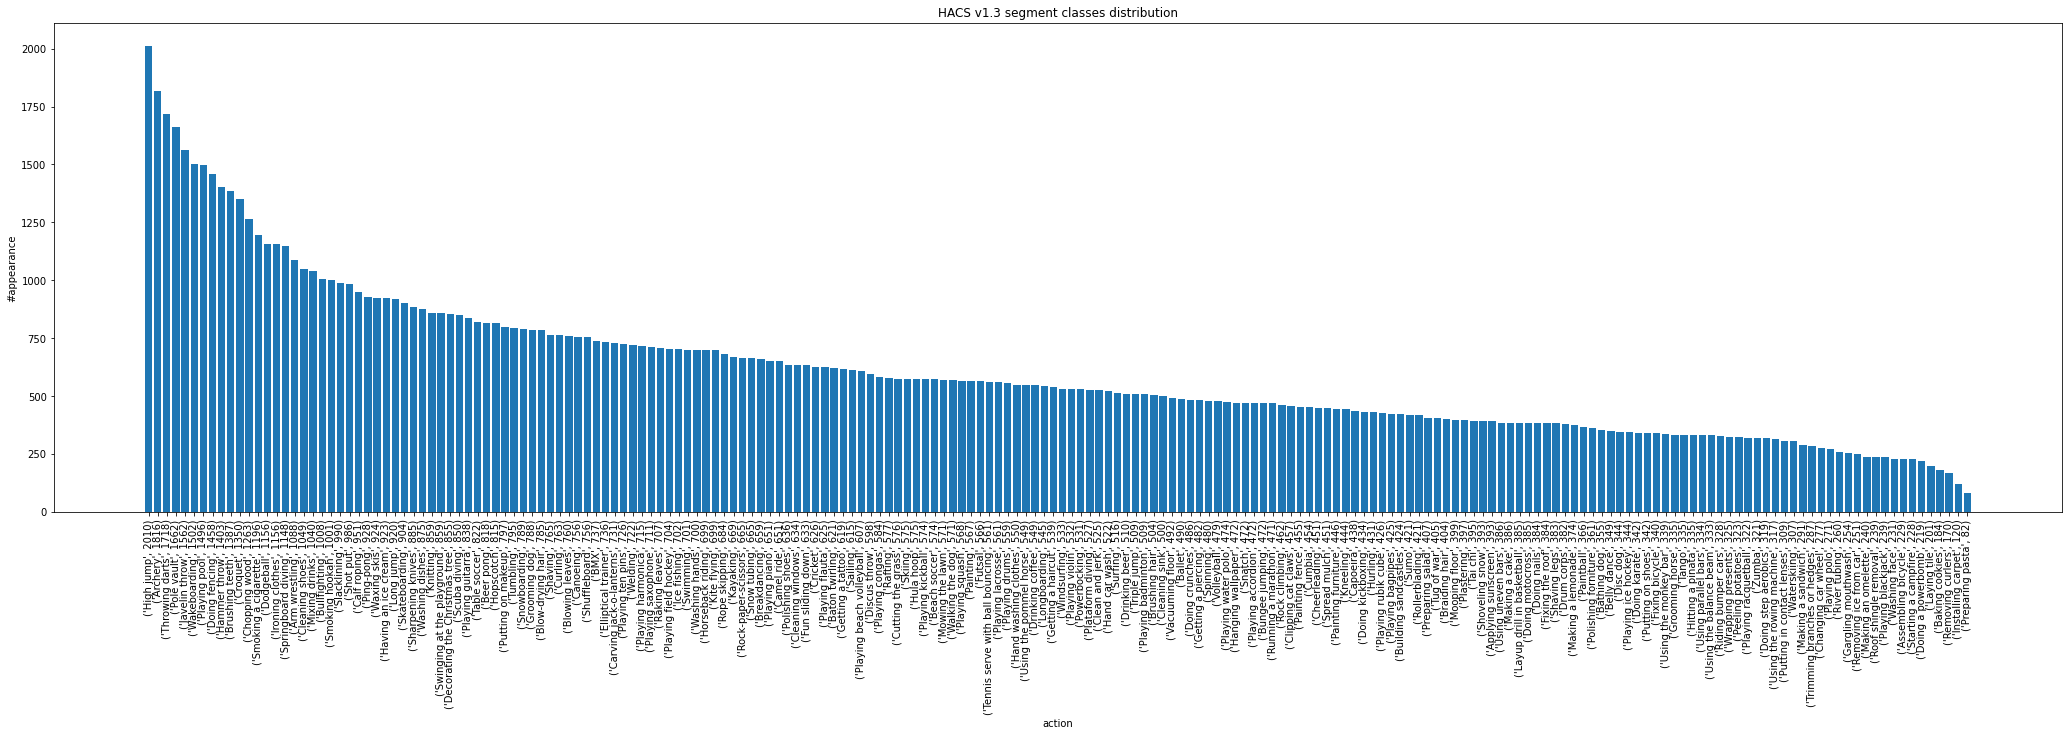

In [23]:
from collections import Counter
from matplotlib import pyplot as plt
result = Counter(class_distribution)

plt.figure(figsize=(36,9))
plt.clf()
plt.title('HACS v1.3 segment classes distribution')
plt.xlabel('action')
plt.ylabel('#appearance')

plt.bar(range(len(result.keys())),sorted(result.values(), reverse=True))

plt.xticks(range(len(result.keys())),sorted(result.items(), key=lambda d: d[1], reverse=True) , rotation=90)
plt.show()

In [24]:
# Some basic stats analyze
appearance = np.array([ num for num in result.values()])
print(f'mean: {np.mean(appearance)}, std: {np.std(appearance)}')

mean: 611.52, std: 328.2584189324015


In [26]:
# I am curious how many kind of classes in average are there in all videos
num_classes_per_video = []
num_segs_per_video = []
for video in all_videos:
    if video.subset != 'validation':
        continue
    classes = {}
    num_segs_per_video.append(video.get_num_seg())
    for seg in video.segments:
        if seg.action_label not in classes.keys():
            classes[seg.action_label] = 1
        else:
            classes[seg.action_label] += 1
    if not 0 <= len(classes.keys()) <= 1:
        print(f'{video.video_id} has {(classes.keys())}')
    num_classes_per_video.append(len(classes.keys()))
print(Counter(num_classes_per_video))
print(Counter(num_segs_per_video))
print(f'avg #class per video is {np.mean(num_classes_per_video)}\n'
     f'avg #seg per video is {np.mean(num_segs_per_video)}\n')

# training:
# avg #class per video is 1.0004785579453912
# avg #seg per video is 2.814665142370989

# validation:
# avg #class per video is 1.00150476508945
# avg #seg per video is 2.7480354455776625
#
# As we can see nearly every video has only on kind of action
# And most of them are synonyms.

6JPiGMaeQJo has dict_keys(['Painting furniture', 'Polishing forniture'])
AZfZ9GoyD9Y has dict_keys(['Drum corps', 'Playing bagpipes'])
ArUc5OehbmE has dict_keys(['Long jump', 'Triple jump'])
D704rAfen9E has dict_keys(['Discus throw', 'Shot put'])
Fj3TuCgLdHw has dict_keys(['Playing racquetball', 'Playing squash'])
GkDRj1GlHig has dict_keys(['Assembling bicycle', 'Fixing bicycle'])
QdSQe25G1YQ has dict_keys(['Plataform diving', 'Springboard diving'])
jt3mevqJ_fQ has dict_keys(['Blow-drying hair', 'Removing curlers'])
pyKfWXoAJnY has dict_keys(['Skiing', 'Snowboarding'])
Counter({1: 5972, 2: 9})
Counter({1: 2825, 2: 1074, 3: 616, 4: 388, 5: 327, 6: 236, 7: 141, 8: 99, 9: 83, 10: 55, 12: 35, 11: 33, 14: 15, 13: 15, 19: 5, 21: 5, 18: 5, 16: 5, 15: 5, 22: 4, 20: 3, 17: 3, 28: 1, 24: 1, 27: 1, 25: 1})
avg #class per video is 1.00150476508945
avg #seg per video is 2.7480354455776625



122304


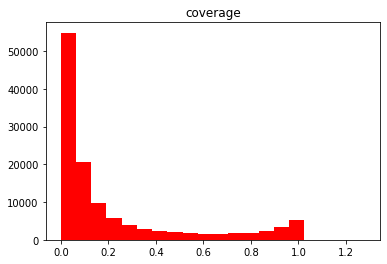

In [27]:
# Now I also want to find out the coverage distribution of segments
# This is extremly important if using an anchor based model
print(len(all_segs))
coverages = [seg.coverage for seg in all_segs]
n, bins, patches = plt.hist(coverages,bins=20,color='r')
plt.title("coverage")
plt.show()
# This is strange, it is not Gaussian-ish

4n8zXCsLycU 155.458333:
0.0->152.35: Playing racquetball
0.81->8.94: Playing squash
15.31->18.85: Playing squash
24.28->33.52: Playing squash
35.44->42.91: Playing squash
49.01->51.41: Playing squash
57.05->59.54: Playing squash
70.54->73.69: Playing squash
80.64->83.39: Playing squash
88.52->92.18: Playing squash
99.47->105.84: Playing squash
108.03->113.61: Playing squash
115.95->118.66: Playing squash
122.87->128.61: Playing squash
132.3->142.91: Playing squash
148.35->152.27: Playing squash
7H_ZBxq9P7Q 22.666667:
0.07->22.59: Blowing leaves
0.53->12.23: Blowing leaves
7JdSW4wsmlA 180.458333:
0.0->0.01: Doing motocross
0.02->0.04: Doing motocross
0.06->0.09: Doing motocross
0.42->231.55: Doing motocross
PxWaSkMZUBU 76.958333:
0.02->60.3: Playing racquetball
2.66->13.68: Playing squash
18.43->24.04: Playing squash
33.73->43.61: Playing squash
47.4->60.02: Playing squash
QITelb8O474 3.375:
0.02->3.81: Gargling mouthwash
dK4xeGODKHU 219.25:
6.09->13.41: Springboard diving
16.11->219.24

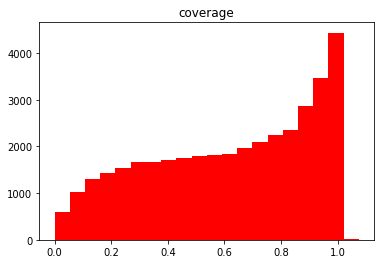

In [31]:
# now I want to find out the coverage of all segments in videos
coverages = []
has_overlap = 0
for video in all_videos:
    if video.subset != 'training':
        continue
    c = 0
    for seg in video.segments:
        c += float(seg.coverage)
    if c > 1.1:
        has_overlap += 1
        print(f'{video.video_id} {video.duration}:')
        for seg in video.segments:
            print(f'{seg.start}->{seg.end}: {seg.action_label}')
        continue
    coverages.append(c)
print(f'{has_overlap}/{has_overlap + len(coverages)}:{has_overlap / len(coverages)} has overlapping.')
plt.clf()
n, bins, patches = plt.hist(coverages,bins=20,color='r')
plt.title("coverage")
plt.show()

# This really tells something, there seems to be some miss-labeling in the annotation

In [30]:
# Besides those outliers, the distribution is like stepping up, with mean and std
print(np.mean(coverages), np.std(coverages))

0.6155072166732078 0.2863230138608233
